# Adaptive/Learning Strategies
* reinforcement learning style (Q-learning)

In [1]:
# Imports and path setup
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from typing import Tuple, Dict

# Ensure we can import modules from the main project
sys.path.append("..")  # Adjust if your notebook is already at the root


In [2]:
# Roulette environment

from config import BET_LIMITS, PAYOUTS
from utils import spin_wheel, is_red, is_black, is_even, is_odd, is_high, is_low

class RouletteEnv:
    def __init__(self, starting_bankroll=1000):
        self.starting_bankroll = starting_bankroll
        self.reset()

    def reset(self):
        self.bankroll = self.starting_bankroll
        self.history = []
        self.round = 0
        return self.get_state()

    def get_state(self):
        return {
            "bankroll": self.bankroll,
            "last_outcome": self.history[-1]["outcome"] if self.history else None,
            "last_win": self.history[-1]["win"] if self.history else None
        }

    def step(self, action: Dict) -> Tuple[Dict, float, bool, Dict]:
        self.round += 1

        if self.bankroll < BET_LIMITS["outside"]["min"]:
            return self.get_state(), 0.0, True, {"bankrupt": True}

        outcome = spin_wheel()
        win = self.evaluate(action, outcome)
        payout = action["amount"] * PAYOUTS[action["type"]] if win else -action["amount"]
        self.bankroll += payout

        self.history.append({
            "round": self.round,
            "outcome": outcome,
            "bet": action,
            "win": win,
            "payout": payout,
            "bankroll": self.bankroll
        })

        reward = payout

        # 🎯 Reward shaping
        # Penalize bust
        if self.bankroll < BET_LIMITS["outside"]["min"]:
            reward -= 200

        # Reward for growing bankroll > 1.5x starting
        elif self.bankroll > self.starting_bankroll * 1.5:
            reward += 50

        # Bonus for surviving long
        if self.round % 100 == 0:
            reward += 10

        done = self.bankroll < BET_LIMITS["outside"]["min"] or self.round >= 1000
        return self.get_state(), reward, done, {"outcome": outcome, "win": win, "payout": payout}

    def evaluate(self, action, outcome):
        if action["type"] == "red":
            return is_red(outcome)
        elif action["type"] == "black":
            return is_black(outcome)
        elif action["type"] == "odd":
            return is_odd(outcome)
        elif action["type"] == "even":
            return is_even(outcome)
        elif action["type"] == "high":
            return is_high(outcome)
        elif action["type"] == "low":
            return is_low(outcome)
        elif action["type"] == "straight":
            return outcome == action["target"]
        return False


In [3]:
# Define action and state space

# 🔹 ACTION SPACE
# Each action is (bet_type, bet_target)
# Outside bets only for now (fixed amount handled in env)

BET_TYPES = ["red", "black", "even", "odd", "high", "low"]
ACTIONS = [{"type": bet_type, "target": bet_type} for bet_type in BET_TYPES]

# Optional: add inside "straight" bets (e.g., on number 0–36)
STRAIGHT_NUMBERS = list(range(37))  # American wheel includes 0–36 (you can add '00' if needed)
ACTIONS += [{"type": "straight", "target": n} for n in STRAIGHT_NUMBERS]

# 📦 Total number of actions
ACTION_SPACE_SIZE = len(ACTIONS)


# 🔹 STATE SPACE
# We'll encode state as a tuple of:
# (bankroll bucket, last_win [0/1], last_outcome_bin)

def encode_state(state, bin_size=100):
    # Bankroll: binned into buckets of $100
    bankroll_bin = min(int(state["bankroll"] // bin_size), 20)  # Cap at $2000+

    # Last win: boolean
    last_win = 1 if state["last_win"] else 0 if state["last_win"] is not None else 0

    # Last outcome: 0–36 mapped to bins of 0–5 (or straight 0–36 for fine-grain)
    if isinstance(state["last_outcome"], int):
        outcome_bin = state["last_outcome"] // 6  # 6 buckets
    else:
        outcome_bin = 0  # If None or '00'

    return (bankroll_bin, last_win, outcome_bin)


In [ ]:
# Q-table initialization and training loop

Q = {}

# Hyperparameters
alpha = 0.1         # learning rate
gamma = 0.95        # discount factor
epsilon = 1.0       # exploration rate (start high)
min_epsilon = 0.1
epsilon_decay = 0.995

episodes = 1000
max_steps = 1000
fixed_bet_amount = 20

# Training loop
episode_rewards = []
episode_lengths = []

for ep in range(episodes):
    env = RouletteEnv(starting_bankroll=1000)
    state = encode_state(env.reset())
    total_reward = 0
    step = 0

    for step in range(max_steps):
        # Ensure Q[state] exists
        if state not in Q:
            Q[state] = np.zeros(ACTION_SPACE_SIZE)

        # Choose action (epsilon-greedy)
        if random.random() < epsilon:
            action_idx = random.randint(0, ACTION_SPACE_SIZE - 1)
        else:
            action_idx = int(np.argmax(Q[state]))

        action = ACTIONS[action_idx]
        action["amount"] = fixed_bet_amount

        next_state_raw, reward, done, info = env.step(action)
        next_state = encode_state(next_state_raw)

        # Initialize Q[next_state] if needed
        if next_state not in Q:
            Q[next_state] = np.zeros(ACTION_SPACE_SIZE)

        # Q-learning update
        old_value = Q[state][action_idx]
        next_max = np.max(Q[next_state])
        Q[state][action_idx] = old_value + alpha * (reward + gamma * next_max - old_value)

        state = next_state
        total_reward += reward

        if done:
            break

    # Decay exploration rate
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    episode_rewards.append(total_reward)
    episode_lengths.append(step + 1)

    if (ep + 1) % 100 == 0:
        print(f"Episode {ep+1}/{episodes} | Total Reward: {total_reward:.2f} | Steps: {step+1} | Epsilon: {epsilon:.3f}")


Episode 100/1000 | Total Reward: 1160.00 | Steps: 178 | Epsilon: 0.606
Episode 200/1000 | Total Reward: -1190.00 | Steps: 132 | Epsilon: 0.367
Episode 300/1000 | Total Reward: -1200.00 | Steps: 50 | Epsilon: 0.222
Episode 400/1000 | Total Reward: 43650.00 | Steps: 1000 | Epsilon: 0.135
Episode 500/1000 | Total Reward: -1190.00 | Steps: 152 | Epsilon: 0.100
Episode 600/1000 | Total Reward: -1200.00 | Steps: 56 | Epsilon: 0.100
Episode 700/1000 | Total Reward: -1190.00 | Steps: 146 | Epsilon: 0.100
Episode 800/1000 | Total Reward: -710.00 | Steps: 430 | Epsilon: 0.100
Episode 900/1000 | Total Reward: -1200.00 | Steps: 96 | Epsilon: 0.100
Episode 1000/1000 | Total Reward: 170.00 | Steps: 240 | Epsilon: 0.100


## Visualizations

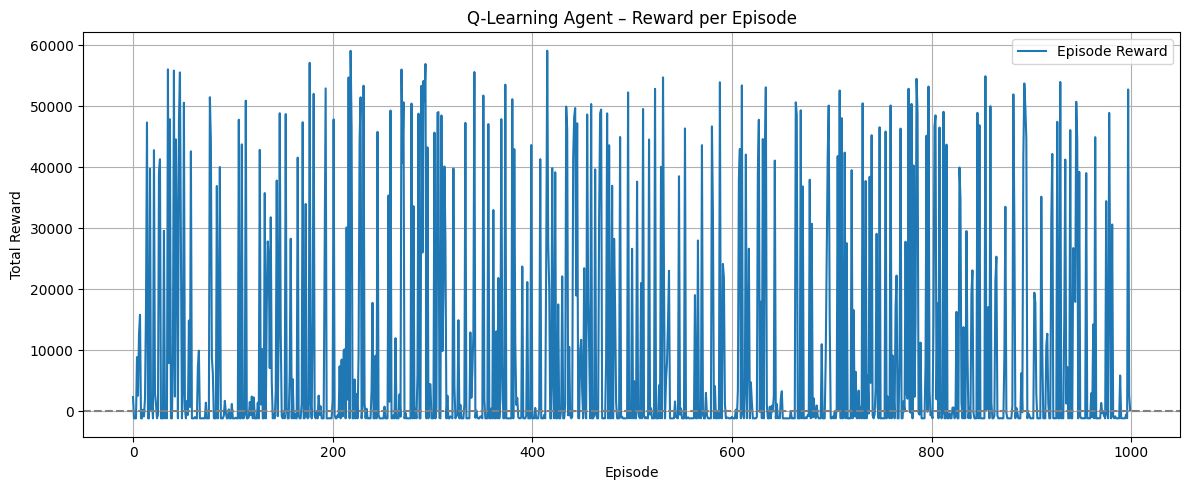

In [5]:
# Learning curve – total reward per episode
plt.figure(figsize=(12, 5))
plt.plot(episode_rewards, label="Episode Reward")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Q-Learning Agent – Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


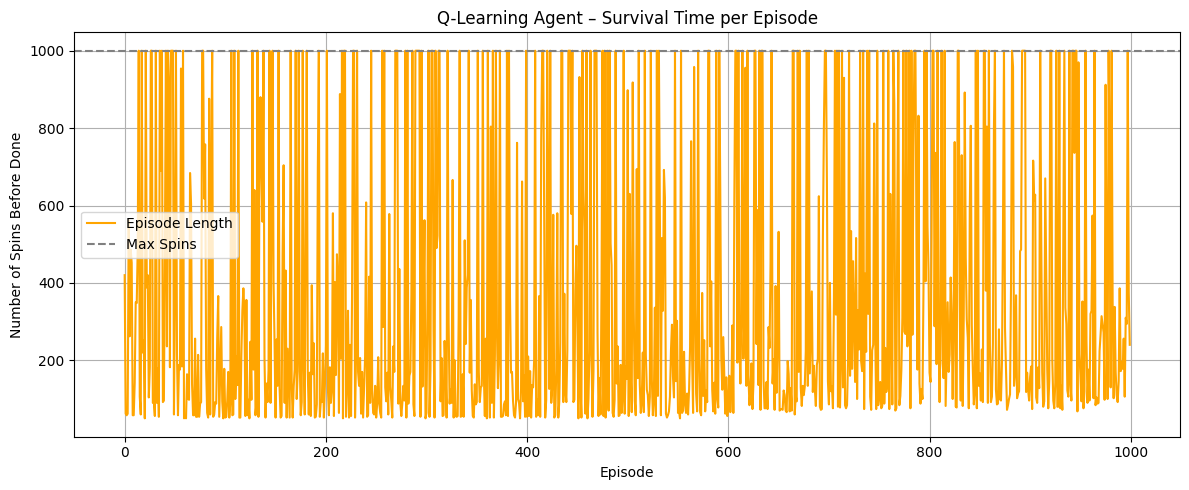

In [6]:
# Episode length – how many spins survived
plt.figure(figsize=(12, 5))
plt.plot(episode_lengths, label="Episode Length", color='orange')
plt.axhline(y=1000, color='gray', linestyle='--', label="Max Spins")
plt.title("Q-Learning Agent – Survival Time per Episode")
plt.xlabel("Episode")
plt.ylabel("Number of Spins Before Done")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Inspection & Testing The Agent

In [7]:
# Top Q-values learned by the agent
top_q = []

for state, q_vals in Q.items():
    best_action_idx = int(np.argmax(q_vals))
    top_q.append({
        "State": state,
        "Action Index": best_action_idx,
        "Action": ACTIONS[best_action_idx],
        "Q-Value": q_vals[best_action_idx]
    })

top_q_df = pd.DataFrame(top_q)
top_q_df = top_q_df.sort_values(by="Q-Value", ascending=False).head(10)
top_q_df


,State,Action Index,Action,Q-Value
158,"(20, 1, 6)",38,"{'type': 'straight', 'target': 32, 'amount': 20}",1058.571911
180,"(20, 0, 1)",13,"{'type': 'straight', 'target': 7, 'amount': 20}",1042.758719
161,"(20, 0, 4)",4,"{'type': 'high', 'target': 'high', 'amount': 20}",1024.409381
95,"(20, 0, 5)",4,"{'type': 'high', 'target': 'high', 'amount': 20}",1019.692943
160,"(20, 0, 3)",2,"{'type': 'even', 'target': 'even', 'amount': 20}",1018.114648
184,"(20, 1, 4)",41,"{'type': 'straight', 'target': 35, 'amount': 20}",1017.198819
181,"(20, 1, 5)",17,"{'type': 'straight', 'target': 11, 'amount': 20}",1014.526537
96,"(20, 0, 2)",5,"{'type': 'low', 'target': 'low', 'amount': 20}",1013.996309
94,"(20, 1, 3)",6,"{'type': 'straight', 'target': 0, 'amount': 20}",1008.191180
179,"(20, 1, 2)",24,"{'type': 'straight', 'target': 18, 'amount': 20}",1006.714279


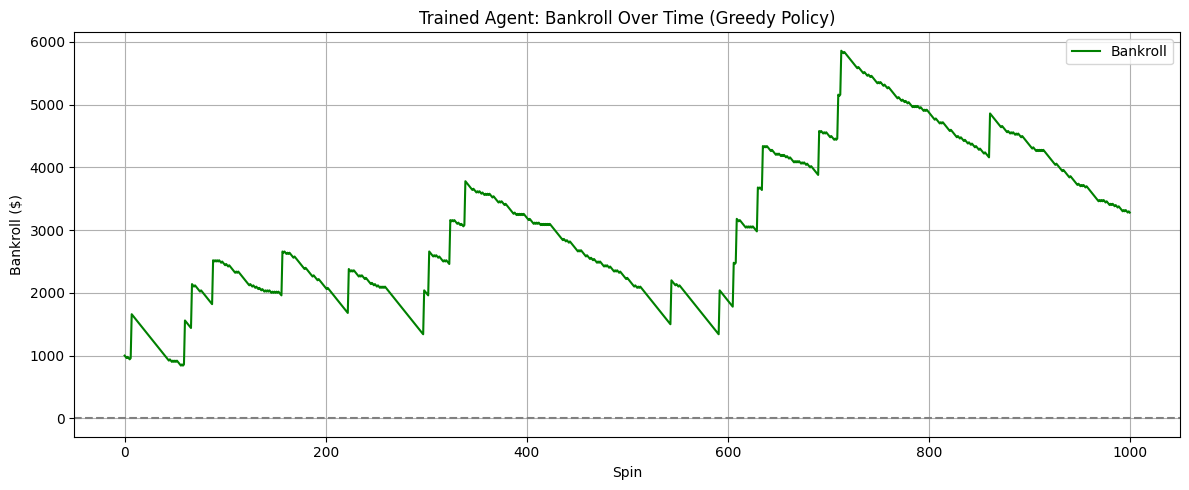

In [8]:
# Test trained agent on new sequence
env = RouletteEnv(starting_bankroll=1000)
state = encode_state(env.reset())
bankroll_history = [env.bankroll]
reward_history = []
done = False

while not done:
    if state not in Q:
        action_idx = random.randint(0, ACTION_SPACE_SIZE - 1)
    else:
        action_idx = int(np.argmax(Q[state]))

    action = ACTIONS[action_idx].copy()
    action["amount"] = fixed_bet_amount

    next_state_raw, reward, done, info = env.step(action)
    next_state = encode_state(next_state_raw)

    state = next_state
    bankroll_history.append(env.bankroll)
    reward_history.append(reward)

# Plot bankroll over time
plt.figure(figsize=(12, 5))
plt.plot(bankroll_history, label="Bankroll", color='green')
plt.title("Trained Agent: Bankroll Over Time (Greedy Policy)")
plt.xlabel("Spin")
plt.ylabel("Bankroll ($)")
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# Compare trained agent vs flat bettor over 100 runs
def evaluate_agent(agent_policy_fn, label, runs=100):
    rewards = []
    spins = []

    for _ in range(runs):
        env = RouletteEnv()
        state = encode_state(env.reset())
        total_reward = 0
        count = 0
        done = False

        while not done:
            action_idx = agent_policy_fn(state)
            action = ACTIONS[action_idx].copy()
            action["amount"] = fixed_bet_amount
            next_state_raw, reward, done, _ = env.step(action)
            state = encode_state(next_state_raw)
            total_reward += reward
            count += 1

        rewards.append(total_reward)
        spins.append(count)

    return pd.DataFrame({
        "Strategy": label,
        "Reward": rewards,
        "Spins": spins
    })

# Agent policy: greedy Q-table
def q_policy(state):
    if state not in Q:
        return random.randint(0, ACTION_SPACE_SIZE - 1)
    return int(np.argmax(Q[state]))

# Flat bet policy: always bet "red" (index 0)
def flat_policy(state):
    return 0  # Assuming ACTIONS[0] = {'type': 'red', ...}

# Run evaluations
df_q = evaluate_agent(q_policy, "Q-Learning Agent")
df_flat = evaluate_agent(flat_policy, "Flat Betting")

# Combine
df_eval = pd.concat([df_q, df_flat])


In [10]:
df_eval

,Strategy,Reward,Spins
0,Q-Learning Agent,12460,608
1,Q-Learning Agent,50350,1000
2,Q-Learning Agent,-1190,114
3,Q-Learning Agent,-1190,122
4,Q-Learning Agent,50570,1000
...,...,...,...
95,Flat Betting,-1150,506
96,Flat Betting,-620,1000
97,Flat Betting,-140,1000
98,Flat Betting,-1140,654


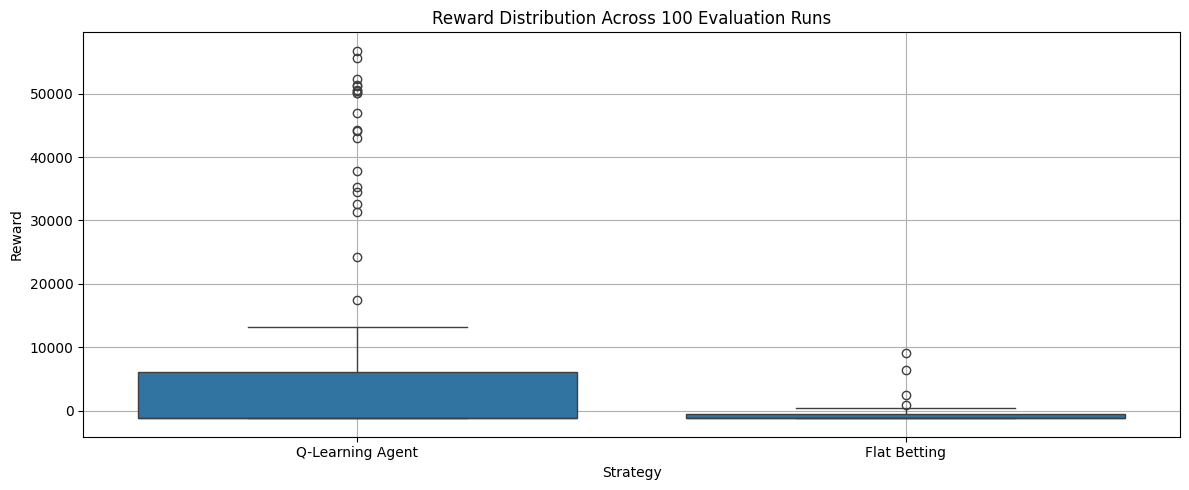

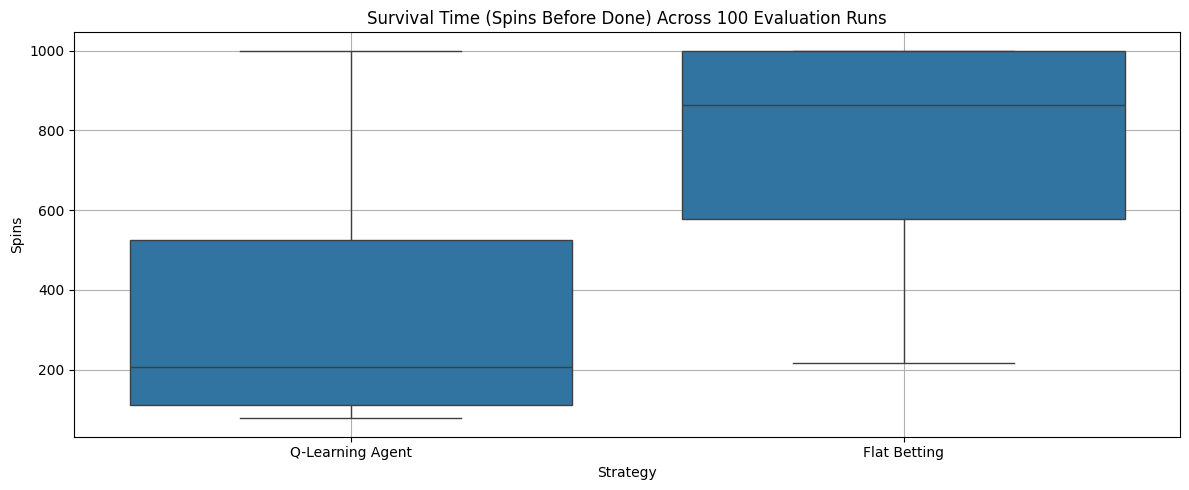

In [11]:
# Distribution comparison
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_eval, x="Strategy", y="Reward")
plt.title("Reward Distribution Across 100 Evaluation Runs")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_eval, x="Strategy", y="Spins")
plt.title("Survival Time (Spins Before Done) Across 100 Evaluation Runs")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Generate a summary table of mean, median, std, max, and min for reward and spins
summary_table = (
    df_eval.groupby("Strategy")
    .agg(
        Reward_Mean=("Reward", "mean"),
        Reward_Median=("Reward", "median"),
        Reward_Std=("Reward", "std"),
        Reward_Max=("Reward", "max"),
        Reward_Min=("Reward", "min"),
        Spins_Mean=("Spins", "mean"),
        Spins_Median=("Spins", "median"),
    )
    .round(2)
)

summary_table

,Reward_Mean,Reward_Median,Reward_Std,Reward_Max,Reward_Min,Spins_Mean,Spins_Median
Strategy,,,,,,,
Flat Betting,-626.0,-1120.0,1348.01,9180,-1180,775.36,865.0
Q-Learning Agent,8522.7,-1180.0,18145.89,56770,-1200,374.66,208.0


In [14]:
# Percent of profitable runs
profit_summary = (
    df_eval.assign(Profitable=lambda df: df["Reward"] > 0)
    .groupby("Strategy")["Profitable"]
    .mean()
    .mul(100)
    .round(2)
    .rename("Percent Profitable")
)

profit_summary


Strategy
Flat Betting         8.0
Q-Learning Agent    33.0
Name: Percent Profitable, dtype: float64